In [14]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.optim as optim
from efficientnet import EfficientNet, base_model, phi_values
import os
import json
import time
#import cv2

In [15]:
#device : GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
version = "b0"
phi, res, drop_rate = phi_values[version]

In [17]:
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(res),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((res, res)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [18]:
#data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
data_root = os.getcwd()
image_path = data_root + "/data/"  # flower data set path
train_dataset = datasets.ImageFolder(root=image_path + "/train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)

In [19]:
cd_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in cd_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices_efficient.json', 'w') as json_file:
    json_file.write(json_str)

In [20]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=0)

validate_dataset = datasets.ImageFolder(root=image_path + "/val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=0)

test_data_iter = iter(validate_loader)
test_image, test_label = test_data_iter.next()
print(test_image[0].size(),type(test_image[0]))
print(test_label[0],test_label[0].item(),type(test_label[0]))

torch.Size([3, 224, 224]) <class 'torch.Tensor'>
tensor(0) 0 <class 'torch.Tensor'>


In [21]:
net = EfficientNet(version=version,num_classes=9)

net.to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0002)

save_path = './EfficientNet.pth'

best_acc = 0.0

In [22]:
# a dictionary used to store all loss and accuracy
stats = {"train_loss":[],"train_acc":[],"val_acc":[],"val_loss":[]}

for epoch in range(40):
    # train
    net.train()
    running_loss = 0.0
    t1 = time.perf_counter()
    step_acc = []
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = net(images.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        # get the training accuracy
        _, predicted = outputs.max(1)
        correct = (predicted == labels.to(device)).sum().item()

        #calculate the training accuracy
        step_acc.append(correct/len(predicted))

        # print train process
        rate = (step + 1) / len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.3f}".format(int(rate * 100), a, b, loss), end="")
    print()
    print(time.perf_counter()-t1)


    # validate
    net.eval()  
    acc = 0.0  # accumulate accurate number / epoch
    val_loss = 0.0

    with torch.no_grad():
        for v_step,val_data in enumerate(validate_loader):
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]
            acc += (predict_y == val_labels.to(device)).sum().item()
            val_loss += loss_function(outputs, val_labels.to(device)).item()
        val_accurate = acc / val_num
        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
        print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
              (epoch + 1, running_loss / step, val_accurate))
    
    # save the status
    print("train_accuracy is: " + str(np.mean(step_acc)))
    stats["train_loss"].append(running_loss / step)
    stats["train_acc"].append(np.mean(step_acc))
    stats["val_acc"].append(val_accurate)
    stats["val_loss"].append(val_loss / v_step)

print('Finished Training')

train loss: 100%[**************************************************->]1.949
27.582642600000327
[epoch 1] train_loss: 1.982  test_accuracy: 0.357
train_accuracy is: 0.24632352941176472
train loss: 100%[**************************************************->]1.300
27.617589500000122
[epoch 2] train_loss: 1.773  test_accuracy: 0.354
train_accuracy is: 0.3092830882352941
train loss: 100%[**************************************************->]2.538
28.233031700000083
[epoch 3] train_loss: 1.658  test_accuracy: 0.415
train_accuracy is: 0.3474264705882353
train loss: 100%[**************************************************->]1.543
28.367564799999855
[epoch 4] train_loss: 1.604  test_accuracy: 0.478
train_accuracy is: 0.3713235294117647
train loss: 100%[**************************************************->]1.733
27.97606510000014
[epoch 5] train_loss: 1.542  test_accuracy: 0.504
train_accuracy is: 0.40441176470588236
train loss: 100%[**************************************************->]1.619
29.07761

In [30]:
def plot_figure(name, stats):
  fig_1 = plt.figure(figsize=(8, 4))
  ax_1 = fig_1.add_subplot(111)

  k_1 = "train_loss"
  k_2 = "val_loss"
  item = stats[k_1]
  ax_1.plot(np.arange(1, len(item)+1), item, label='{}_{}'.format(name, k_2))
  
  
  item = stats[k_2]
  ax_1.plot(np.arange(1, len(item)+1), item, label='{}_{}'.format(name, k_1))

  ax_1.legend(loc=0)
  ax_1.set_ylabel('Loss')
  ax_1.set_xlabel('Epoch number')

  # Plot the change in the validation and training set accuracy over training.
  fig_2 = plt.figure(figsize=(8, 4))
  ax_2 = fig_2.add_subplot(111)

  k_1 = "train_acc"
  k_2 = "val_acc"
  item = stats[k_1]
  ax_2.plot(np.arange(1, len(item)+1), item, label='{}_{}'.format(name, k_2))
  
  item = stats[k_2]
  ax_2.plot(np.arange(1, len(item)+1), item, label='{}_{}'.format(name, k_1))


  ax_2.legend(loc=0)
  ax_2.set_ylabel('Accuracy')
  ax_2.set_xlabel('Epoch number')

  return fig_1, fig_2

(<Figure size 576x288 with 1 Axes>, <Figure size 576x288 with 1 Axes>)

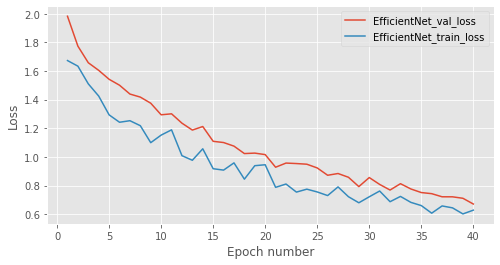

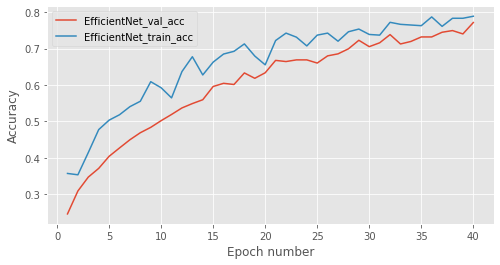

In [31]:
%matplotlib inline
plt.style.use('ggplot')
plot_figure("EfficientNet",stats)

In [24]:
model = EfficientNet(num_classes=9, version=version)
save_path = "EfficientNet.pth"
model.load_state_dict(torch.load(save_path))
model.eval()

EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): CNNBlock(
      (cnn): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): InvertedResidualBlock(
      (conv): Sequential(
        (0): CNNBlock(
          (cnn): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SqueezeExcitation(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(

In [25]:
""" with torch.no_grad():
    for test_data in test_loader:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))
        predict_y = torch.max(outputs, dim=1)[1]
        acc += (predict_y == val_labels.to(device)).sum().item()
    val_accurate = acc / val_num
    if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)
    print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
            (epoch + 1, running_loss / step, val_accurate)) """

" with torch.no_grad():\n    for test_data in test_loader:\n        val_images, val_labels = val_data\n        outputs = net(val_images.to(device))\n        predict_y = torch.max(outputs, dim=1)[1]\n        acc += (predict_y == val_labels.to(device)).sum().item()\n    val_accurate = acc / val_num\n    if val_accurate > best_acc:\n        best_acc = val_accurate\n        torch.save(net.state_dict(), save_path)\n    print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %\n            (epoch + 1, running_loss / step, val_accurate)) "